# Intro

5개의 bandit algorithm 을 가상의 MAB 문제를 만들어서 성능을 비교하는 Notebook입니다.
- EpsilonGreedy / Annealing EpsilonGreedy / Softmax / Annealing Softmax / LinUCB 

# Setting

## Import packages

5개의 알고리즘은 bandit_algorithm.py에 구현해 두었습니다.

In [1]:
from bandit_algorithm  import *

그 외 data generation 및 절차에 필요한 package 불러오기

In [2]:
import math ; import random
import pandas as pd 
import numpy as np

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings

warnings.filterwarnings(action='ignore')

## Generate test sets

데이터는 모두 classification 문제인 IRIS 데이터와 Kaggle의 [music genre classification](https://www.kaggle.com/datasets/purumalgi/music-genre-classification)을 이용하였습니다. 

Bandit 알고리즘 실험을 위해 다음과 같은 방법으로 모의 데이터를 생성하였습니다.
- Context(X) : classification dataset의 변수
- Reward(R) : 임의의 분류 모형을 이용해 계산한 해당 범주에 속한 추정 확률

총 3개의 모의 데이터셋($X_i, R_i, \ i = 1, \cdots, 3$)을 생성하였고, 각각의 특징은 다음과 같습니다.
- $i=1$ : iris 데이터셋에 logit 모형을 적합해서 구한 추정 확률을 R로 둠
- $i=2$ : music genre 데이터셋에 random forest 모형을 적합해서 구한 추정 확률을 R로 둠
- $i=2$ : music genre 데이터셋에 logit 모형을 적합해서 구한 추정 확률을 R로 둠

이런 방식을 통해, $R_i$가 $X_i$에 dependent한 관계를 가지도록 했습니다. (*$i=1, 3$인 경우에는 선형 관계를 가지지만, $i=2$의 경우 tree 계열의 random forest를 사용했기에 비선형 관계) 

아래는 해당 방법으로 $X_i, R_i$를 생성하는 코드입니다.


In [4]:
data_dir='F:/Data/'

In [5]:
# Data 1 : Iris data + logit
X, y = load_iris(return_X_y=True, as_frame=False) # loading
temp = np.random.permutation(np.arange(150));  # shuffle
X = X[temp] ; y = y[temp] 
scr = StandardScaler()
X = scr.fit_transform(X) # scaling

lr = LogisticRegression(max_iter = 1000000)
lr.fit(X,y)

reward = np.round(lr.predict_proba(X),2)
[len(reward.argmax(axis=1)[reward.argmax(axis=1) ==i])/reward.shape[0] for i in range(reward.shape[1])]

X_1 = X; Reward_1 = reward

In [6]:
# Data 2 : Music genre + RF
# Data 3 : Music genre + logit

music_trn = pd.read_csv(data_dir + 'music_genre_classification_train.csv'); music_trn = music_trn.dropna()
music_tst = pd.read_csv(data_dir + 'music_genre_classification_test.csv'); music_tst = music_tst.dropna()

music_trn_y = music_trn['Class']; music_trn_x = music_trn.drop(['Artist Name', 'Track Name','Class'],axis=1)

music_trn_x = pd.get_dummies(music_trn_x, columns = ['time_signature'], drop_first = True)
music_trn_y = pd.get_dummies(music_trn_y, columns = ['Class'], drop_first = False)

music_tst_x = music_tst.drop(['Artist Name', 'Track Name'],axis=1)
music_tst_x = pd.get_dummies(music_tst_x, columns = ['time_signature'], drop_first = True)

RF = RandomForestClassifier()
RF.fit(music_trn_x,music_trn_y)
Reward_2 = RF.predict_proba(music_tst_x); Reward_2 = np.array([[Reward_2[i][:,1]] for i in range(len(Reward_2))]).reshape(-1,11)

X_2 = np.array(music_tst_x)

music_trn_y = music_trn['Class']

# logit
lr = LogisticRegression(max_iter = 1000000)
lr.fit(music_trn_x,music_trn_y)

# Generate rewards and X for MAB problem
Reward_3 = lr.predict_proba(music_tst_x)
X_3 = X_2 

## EDA on simulated data

MAB 문제 형태의 $X_i, R_i$ set은 다음과 같이 생겼습니다. 

예를 들어, 어떤 쇼핑몰의 랜딩 페이지별로 소비자가 갖는 reward를 추정하는 문제라고 생각하고 설명을 하자면,

- $X_1$은 150명의 고객이 순차적으로 들어오고, 각 고객은 4개의 feature(context)를 가지고 있고, 홈페이지 랜딩 시 후보 A, B, C안(3개) 중 하나만 보고 그에 따른 행동을 하게 됩니다.
- $X_2, \ X_3$의 경우 5063명의 고객, 16개의 feature(context), 11개의 후보를 가지고 있는 문제입니다.

In [7]:
print(X_1.shape, Reward_1.shape)
print(X_2.shape, Reward_2.shape)
print(X_3.shape, Reward_3.shape)

(150, 4) (150, 3)
(5063, 16) (5063, 11)
(5063, 16) (5063, 11)


각 데이터에서 (고객, 랜딩 후보안)의 count를 살펴 보았습니다.

- $X_1$의 경우 1,2,3 세 안이 고객 전체를 보았을 때, 대부분 비슷한 정도의 선호도를 가지고 있습니다.
- $X_2$의 경우 0번 후보의 reward를 느끼는 고객이 가장 많았습니다. 
- $X_3$의 경우 10번 후보의 reward를 느끼는 고객이 가장 많았습니다. 

In [8]:
print(np.round(pd.Series(Reward_1.argmax(axis=1)).value_counts(sort=False) / Reward_1.shape[0],2))
print(np.round(pd.Series(Reward_2.argmax(axis=1)).value_counts(sort=False) / Reward_2.shape[0],2))
print(np.round(pd.Series(Reward_3.argmax(axis=1)).value_counts(sort=False) / Reward_3.shape[0],2))

0    0.33
2    0.35
1    0.32
dtype: float64
1     0.08
2     0.08
0     0.14
7     0.08
8     0.08
4     0.08
5     0.09
3     0.09
10    0.08
9     0.09
6     0.09
dtype: float64
10    0.86
0     0.01
6     0.01
7     0.12
9     0.00
8     0.00
dtype: float64


다음으로 각 데이터에서 $X_i$와 각 안의 reward간의 선형성을 $R^2$를 통해 가늠해 보았습니다.

$i=1$

In [9]:
lin = LinearRegression()
lin.fit(X_1 , Reward_1[:,0])
print(r2_score(Reward_1[:,0], lin.predict(X_1)))

lin.fit(X_1 , Reward_1[:,1])
print(r2_score(Reward_1[:,1], lin.predict(X_1)))

lin.fit(X_1 , Reward_1[:,2])
print(r2_score(Reward_1[:,2], lin.predict(X_1)))

0.9262255616869943
0.3908173492173638
0.7931412125415107


$i=2$

In [10]:
lin = LinearRegression()

for i in range(Reward_2.shape[1]) :     
    lin.fit(X_2 , Reward_2[:,i])
    print(r2_score(Reward_2[:,i], lin.predict(X_2)))

0.004856070164397819
0.00615121844189126
0.004325415376160935
0.0042243760570026545
0.0038459737408440553
0.0019225891295965303
0.0019984509949275697
0.003359790686610742
0.0036766517467222704
0.0028509013649660186
0.0037835826898712233


$i=3$

In [29]:
lin = LinearRegression()

for i in range(Reward_3.shape[1]) :     
    lin.fit(X_3 , Reward_3[:,i])
    print(r2_score(Reward_3[:,i], lin.predict(X_2)))

0.5602556201182893
0.2373611575070773
0.8469935531054427
0.58388674658794
0.5815771546707224
0.272959067184661
0.432658084850826
0.5649031292134377
0.9644563331636056
0.33687173217650934
0.7455633772259922


다음으로 각 데이터에서 후보들의 평균 reward를 보았습니다.

1, 2번은 3 후보가 전체 고객에서 거의 무차별한 평균 리워드를 갖고 있는데에 반해, 3번은 마지막 후보가 뚜렷하게 좋은 대안이 될 것 같습니다.

In [12]:
Reward_1.mean(axis=0)

array([0.33326667, 0.33306667, 0.33353333])

In [13]:
Reward_2.mean(axis=0)

array([0.0931673 , 0.08866604, 0.08874618, 0.09369887, 0.09314662,
       0.09255541, 0.09354093, 0.08503654, 0.0885025 , 0.09221624,
       0.09072337])

In [14]:
Reward_3.mean(axis=0)

array([0.03838901, 0.08996835, 0.07978781, 0.01810455, 0.00831722,
       0.04425623, 0.17308906, 0.04217337, 0.13525981, 0.09021385,
       0.28044076])

# Experiment 1 : Hyper-parameter 값에 따른 performance 변화

3개의 $X_i, R_i$에서 각 알고리즘의 최적의 hyper-parameter를 찾는 실험을 먼저 진행해 보았습니다. 

(*알고리즘별로 hyper-parameter 세팅을 달리하며 순차적으로 고객 유입을 가정하고 grid search를 통해 성능을 확인)

## data set 1 : $X_1 , R_1$

In [15]:
eps_l = []; mean_regret = []; mean_correct = []
for rep in range(10) :
    idx_shfl = np.random.permutation(np.arange(Reward_1.shape[0]))
    Temp_Reward = Reward_1[idx_shfl,:]
    Temp_X = X_1[idx_shfl,:]
    for epsilon in np.linspace(0.0, 1, 101) :
        tester_eps = EpsilonGreedy(epsilon=epsilon, counts = None, values = None)
        tester_eps.initialize(n_arms = Temp_Reward.shape[1])
        d_eps1 = tester_eps.run_simul(Temp_X)

        # epsilon별 mean_regret, mean_correct
        eps_l.append(epsilon)
        mean_regret.append(np.mean(d_eps1.regret))
        mean_correct.append(np.mean(d_eps1.correct))
    
set1_eps1 = pd.DataFrame({'eps':eps_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('epsilon greedy : ')
print(set1_eps1[set1_eps1['mean_regret'] == min(set1_eps1['mean_regret'])])
print(set1_eps1[set1_eps1['mean_correct'] == max(set1_eps1['mean_correct'])])
print('#####')

## epsilon greedy + annealing 100번 ** annealing 고정이라 그냥 100번 해봄
eps_l = []; mean_regret = []; mean_correct = []
for rep in range(10) : 
    idx_shfl = np.random.permutation(np.arange(Reward_1.shape[0]))
    Temp_Reward = Reward_1[idx_shfl,:]
    Temp_X = X_1[idx_shfl,:]

    for trying in range(1,101) :
        tester_eps2 = AnnealingEpsilonGreedy(counts = None, values = None)
        tester_eps2.initialize(n_arms =Temp_Reward.shape[1])
        d_eps2 = tester_eps2.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        eps_l.append(trying)
        mean_regret.append(np.mean(d_eps2.regret))
        mean_correct.append(np.mean(d_eps2.correct))

set1_eps2 = pd.DataFrame({'i':eps_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})


print('epsilon greedy + annealing : ')
print(set1_eps2[set1_eps2['mean_regret'] == min(set1_eps2['mean_regret'])])
print(set1_eps2[set1_eps2['mean_correct'] == max(set1_eps2['mean_correct'])])
print('#####')

## softmax : exp(-5)~ exp(5)까지 temperature 변화시키면서 확인.
temperature_l = []; mean_regret = []; mean_correct = []
for rep in range(10) : 
    idx_shfl = np.random.permutation(np.arange(Reward_1.shape[0]))
    Temp_Reward = Reward_1[idx_shfl,:]
    Temp_X = X_1[idx_shfl,:]
    
    for temp in np.exp(np.linspace(-5,5,101)) :     
        tester_softmax = Softmax(temperature = temp, counts = None, values = None)
        tester_softmax.initialize(n_arms = Temp_Reward.shape[1])
        d_softmax = tester_softmax.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        temperature_l.append(temp)
        mean_regret.append(np.mean(d_softmax.regret))
        mean_correct.append(np.mean(d_softmax.correct))

set1_softmax= pd.DataFrame({'temp':temperature_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})
    
print('softmax : ')
print(set1_softmax[set1_softmax['mean_regret'] == min(set1_softmax['mean_regret'])])
print(set1_softmax[set1_softmax['mean_correct'] == max(set1_softmax['mean_correct'])])
print('#####')

## ucb1 : alpha 변화시켜가면서 실험.

alpha_l = []; mean_regret = []; mean_correct = []
for rep in range(10) : 
    idx_shfl = np.random.permutation(np.arange(Reward_1.shape[0]))
    Temp_Reward = Reward_1[idx_shfl,:]
    Temp_X = X_1[idx_shfl,:]
    for alpha in np.linspace(0,5,101) :     
        tester_ucb1 = UCB1(counts = None, values = None, alpha = alpha)
        tester_ucb1.initialize(n_arms = Temp_Reward.shape[1])
        d_ucb1 = tester_ucb1.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        alpha_l.append(alpha)
        mean_regret.append(np.mean(d_ucb1.regret))
        mean_correct.append(np.mean(d_ucb1.correct))

set1_ucb1 = pd.DataFrame({'alpha':alpha_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('ucb1 : ')
print(set1_ucb1[set1_ucb1['mean_regret'] == min(set1_ucb1['mean_regret'])])
print(set1_ucb1[set1_ucb1['mean_correct'] == max(set1_ucb1['mean_correct'])])
print('#####')

## linUCB : delta 변화시켜가면서 실험.
delta_l = []; mean_regret = []; mean_correct = []
for rep in range(10) : 
    idx_shfl = np.random.permutation(np.arange(Reward_1.shape[0]))
    Temp_Reward = Reward_1[idx_shfl,:]
    Temp_X = X_1[idx_shfl,:]
    for delta in np.linspace(0.01,1,100) :     
        tester_linUCB = LinUCB(alpha = (1+np.sqrt(np.log(2/delta)/2)), n_features = Temp_X.shape[1])
        tester_linUCB.initialize(n_arms =Temp_Reward.shape[1])

        d_linUCB = tester_linUCB.run_simul(Temp_X, Temp_Reward)
        d_linUCB.sum()

        # delta별 mean_regret, mean_correct
        delta_l.append(delta)
        mean_regret.append(np.mean(d_linUCB.regret))
        mean_correct.append(np.mean(d_linUCB.correct))

set1_linUCB= pd.DataFrame({'delta':delta_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('linUCB : ')
print(set1_linUCB[set1_linUCB['mean_regret'] == min(set1_linUCB['mean_regret'])])
print(set1_linUCB[set1_linUCB['mean_correct'] == max(set1_linUCB['mean_correct'])])
print('#####')



epsilon greedy : 
      eps  mean_regret  mean_correct
694  0.88      0.68027      0.313333
      eps  mean_regret  mean_correct
942  0.33      0.80239          0.36
#####
epsilon greedy + annealing : 
      i  mean_regret  mean_correct
733  34       0.4328          0.48
      i  mean_regret  mean_correct
733  34       0.4328          0.48
#####
softmax : 
         temp  mean_regret  mean_correct
434  0.135335     0.465933          0.44
         temp  mean_regret  mean_correct
434  0.135335     0.465933          0.44
#####
ucb1 : 
     alpha  mean_regret  mean_correct
966   2.85     0.455733          0.46
     alpha  mean_regret  mean_correct
966   2.85     0.455733          0.46
#####
linUCB : 
     delta  mean_regret  mean_correct
507   0.08       0.0836      0.853333
513   0.14       0.0836      0.853333
521   0.22       0.0836      0.853333
523   0.24       0.0836      0.853333
526   0.27       0.0836      0.853333
532   0.33       0.0836      0.853333
535   0.36       0.0836      

##  data set 2 : $X_2 , R_2$


In [16]:
eps_l = []; mean_regret = []; mean_correct = []
for rep in range(10) :
    idx_shfl = np.random.permutation(np.arange(Reward_2.shape[0]))
    Temp_Reward = Reward_2[idx_shfl,:]
    Temp_X = X_2[idx_shfl,:]
    for epsilon in np.linspace(0.0, 1, 101) :
        tester_eps = EpsilonGreedy(epsilon=epsilon, counts = None, values = None)
        tester_eps.initialize(n_arms = Temp_Reward.shape[1])
        d_eps1 = tester_eps.run_simul(Temp_Reward)

        # epsilon별 mean_regret, mean_correct
        eps_l.append(epsilon)
        mean_regret.append(np.mean(d_eps1.regret))
        mean_correct.append(np.mean(d_eps1.correct))
    
set2_eps1 = pd.DataFrame({'eps':eps_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('epsilon greedy : ')
print(set2_eps1[set2_eps1['mean_regret'] == min(set2_eps1['mean_regret'])])
print(set2_eps1[set2_eps1['mean_correct'] == max(set2_eps1['mean_correct'])])
print('#####')

## epsilon greedy + annealing 100번 ** annealing 고정이라 그냥 100번 해봄
eps_l = []; mean_regret = []; mean_correct = []
for rep in range(10) : 
    idx_shfl = np.random.permutation(np.arange(Reward_2.shape[0]))
    Temp_Reward = Reward_2[idx_shfl,:]
    Temp_X = X_2[idx_shfl,:]

    for trying in range(1,101) :
        tester_eps2 = AnnealingEpsilonGreedy(counts = None, values = None)
        tester_eps2.initialize(n_arms =Temp_Reward.shape[1])
        d_eps2 = tester_eps2.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        eps_l.append(trying)
        mean_regret.append(np.mean(d_eps2.regret))
        mean_correct.append(np.mean(d_eps2.correct))

set2_eps2 = pd.DataFrame({'i':eps_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})


print('epsilon greedy + annealing : ')
print(set2_eps2[set2_eps2['mean_regret'] == min(set2_eps2['mean_regret'])])
print(set2_eps2[set2_eps2['mean_correct'] == max(set2_eps2['mean_correct'])])
print('#####')

## softmax : exp(-5)~ exp(5)까지 temperature 변화시키면서 확인.
temperature_l = []; mean_regret = []; mean_correct = []
for rep in range(10) : 
    idx_shfl = np.random.permutation(np.arange(Reward_2.shape[0]))
    Temp_Reward = Reward_2[idx_shfl,:]
    Temp_X = X_2[idx_shfl,:]
    
    for temp in np.exp(np.linspace(-5,5,101)) :     
        tester_softmax = Softmax(temperature = temp, counts = None, values = None)
        tester_softmax.initialize(n_arms = Temp_Reward.shape[1])
        d_softmax = tester_softmax.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        temperature_l.append(temp)
        mean_regret.append(np.mean(d_softmax.regret))
        mean_correct.append(np.mean(d_softmax.correct))

set2_softmax= pd.DataFrame({'temp':temperature_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})
    
print('softmax : ')
print(set2_softmax[set2_softmax['mean_regret'] == min(set2_softmax['mean_regret'])])
print(set2_softmax[set2_softmax['mean_correct'] == max(set2_softmax['mean_correct'])])
print('#####')

## ucb1 : alpha 변화시켜가면서 실험.

alpha_l = []; mean_regret = []; mean_correct = []
for rep in range(10) : 
    idx_shfl = np.random.permutation(np.arange(Reward_2.shape[0]))
    Temp_Reward = Reward_2[idx_shfl,:]
    Temp_X = X_2[idx_shfl,:]
    for alpha in np.linspace(0,5,101) :     
        tester_ucb1 = UCB1(counts = None, values = None, alpha = alpha)
        tester_ucb1.initialize(n_arms = Temp_Reward.shape[1])
        d_ucb1 = tester_ucb1.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        alpha_l.append(alpha)
        mean_regret.append(np.mean(d_ucb1.regret))
        mean_correct.append(np.mean(d_ucb1.correct))

set2_ucb1 = pd.DataFrame({'alpha':alpha_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('ucb1 : ')
print(set2_ucb1[set2_ucb1['mean_regret'] == min(set2_ucb1['mean_regret'])])
print(set2_ucb1[set2_ucb1['mean_correct'] == max(set2_ucb1['mean_correct'])])
print('#####')

## linUCB : delta 변화시켜가면서 실험.
delta_l = []; mean_regret = []; mean_correct = []
for rep in range(10) : 
    idx_shfl = np.random.permutation(np.arange(Reward_2.shape[0]))
    Temp_Reward = Reward_2[idx_shfl,:]
    Temp_X = X_2[idx_shfl,:]
    for delta in np.linspace(0.01,1,100) :     
        tester_linUCB = LinUCB(alpha = (1+np.sqrt(np.log(2/delta)/2)), n_features = Temp_X.shape[1])
        tester_linUCB.initialize(n_arms =Temp_Reward.shape[1])

        d_linUCB = tester_linUCB.run_simul(Temp_X, Temp_Reward)
        d_linUCB.sum()

        # delta별 mean_regret, mean_correct
        delta_l.append(delta)
        mean_regret.append(np.mean(d_linUCB.regret))
        mean_correct.append(np.mean(d_linUCB.correct))

set2_linUCB= pd.DataFrame({'delta':delta_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('linUCB : ')
print(set2_linUCB[set2_linUCB['mean_regret'] == min(set2_linUCB['mean_regret'])])
print(set2_linUCB[set2_linUCB['mean_correct'] == max(set2_linUCB['mean_correct'])])
print('#####')




epsilon greedy : 
      eps  mean_regret  mean_correct
280  0.78     0.273211      0.095595
     eps  mean_regret  mean_correct
0    0.0     0.276647      0.144183
101  0.0     0.276647      0.144183
202  0.0     0.276647      0.144183
303  0.0     0.276647      0.144183
404  0.0     0.276647      0.144183
505  0.0     0.276647      0.144183
606  0.0     0.276647      0.144183
707  0.0     0.276647      0.144183
808  0.0     0.276647      0.144183
909  0.0     0.276647      0.144183
#####
epsilon greedy + annealing : 
      i  mean_regret  mean_correct
833  34     0.272553      0.096781
      i  mean_regret  mean_correct
194  95     0.278489        0.1349
#####
softmax : 
           temp  mean_regret  mean_correct
302  148.413159     0.273091      0.098953
         temp  mean_regret  mean_correct
303  0.006738     0.276783      0.144381
#####
ucb1 : 
    alpha  mean_regret  mean_correct
55   2.75     0.272701      0.104088
    alpha  mean_regret  mean_correct
55   2.75     0.272701    

##  data set 3 : $X_3 , R_3$


In [17]:
# set 3 : X_3 , Reward_3

eps_l = []; mean_regret = []; mean_correct = []
for rep in range(10) :
    print(rep)
    idx_shfl = np.random.permutation(np.arange(Reward_3.shape[0]))
    Temp_Reward = Reward_3[idx_shfl,:]
    Temp_X = X_3[idx_shfl,:]
    for epsilon in np.linspace(0.0, 1, 101) :
        tester_eps = EpsilonGreedy(epsilon=epsilon, counts = None, values = None)
        tester_eps.initialize(n_arms = Temp_Reward.shape[1])
        d_eps1 = tester_eps.run_simul(Temp_Reward)

        # epsilon별 mean_regret, mean_correct
        eps_l.append(epsilon)
        mean_regret.append(np.mean(d_eps1.regret))
        mean_correct.append(np.mean(d_eps1.correct))
    
set3_eps1 = pd.DataFrame({'eps':eps_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('epsilon greedy : ')
print(set3_eps1[set3_eps1['mean_regret'] == min(set3_eps1['mean_regret'])])
print(set3_eps1[set3_eps1['mean_correct'] == max(set3_eps1['mean_correct'])])
print('#####')

## epsilon greedy + annealing 100번 ** annealing 고정이라 그냥 100번 해봄
eps_l = []; mean_regret = []; mean_correct = []
for rep in range(10) : 
    print(rep)
    idx_shfl = np.random.permutation(np.arange(Reward_3.shape[0]))
    Temp_Reward = Reward_3[idx_shfl,:]
    Temp_X = X_3[idx_shfl,:]

    for trying in range(1,101) :
        tester_eps2 = AnnealingEpsilonGreedy(counts = None, values = None)
        tester_eps2.initialize(n_arms =Temp_Reward.shape[1])
        d_eps2 = tester_eps2.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        eps_l.append(trying)
        mean_regret.append(np.mean(d_eps2.regret))
        mean_correct.append(np.mean(d_eps2.correct))

set3_eps2 = pd.DataFrame({'i':eps_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})


print('epsilon greedy + annealing : ')
print(set3_eps2[set3_eps2['mean_regret'] == min(set3_eps2['mean_regret'])])
print(set3_eps2[set3_eps2['mean_correct'] == max(set3_eps2['mean_correct'])])
print('#####')

## softmax : exp(-5)~ exp(5)까지 temperature 변화시키면서 확인.
temperature_l = []; mean_regret = []; mean_correct = []
for rep in range(10) : 
    print(rep)
    idx_shfl = np.random.permutation(np.arange(Reward_3.shape[0]))
    Temp_Reward = Reward_3[idx_shfl,:]
    Temp_X = X_3[idx_shfl,:]
    
    for temp in np.exp(np.linspace(-5,5,101)) :     
        tester_softmax = Softmax(temperature = temp, counts = None, values = None)
        tester_softmax.initialize(n_arms = Temp_Reward.shape[1])
        d_softmax = tester_softmax.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        temperature_l.append(temp)
        mean_regret.append(np.mean(d_softmax.regret))
        mean_correct.append(np.mean(d_softmax.correct))

set3_softmax= pd.DataFrame({'temp':temperature_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})
    
print('softmax : ')
print(set3_softmax[set3_softmax['mean_regret'] == min(set3_softmax['mean_regret'])])
print(set3_softmax[set3_softmax['mean_correct'] == max(set3_softmax['mean_correct'])])
print('#####')

## ucb1 : alpha 변화시켜가면서 실험.

alpha_l = []; mean_regret = []; mean_correct = []
for rep in range(10) :
    print(rep)
    idx_shfl = np.random.permutation(np.arange(Reward_3.shape[0]))
    Temp_Reward = Reward_3[idx_shfl,:]
    Temp_X = X_3[idx_shfl,:]
    for alpha in np.linspace(0,5,101) :     
        tester_ucb1 = UCB1(counts = None, values = None, alpha = alpha)
        tester_ucb1.initialize(n_arms = Temp_Reward.shape[1])
        d_ucb1 = tester_ucb1.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        alpha_l.append(alpha)
        mean_regret.append(np.mean(d_ucb1.regret))
        mean_correct.append(np.mean(d_ucb1.correct))

set3_ucb1 = pd.DataFrame({'alpha':alpha_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('ucb1 : ')
print(set3_ucb1[set3_ucb1['mean_regret'] == min(set3_ucb1['mean_regret'])])
print(set3_ucb1[set3_ucb1['mean_correct'] == max(set3_ucb1['mean_correct'])])
print('#####')

## linUCB : delta 변화시켜가면서 실험.
delta_l = []; mean_regret = []; mean_correct = []
for rep in range(10) : 
    print(rep)
    idx_shfl = np.random.permutation(np.arange(Reward_3.shape[0]))
    Temp_Reward = Reward_3[idx_shfl,:]
    Temp_X = X_3[idx_shfl,:]
    for delta in np.linspace(0.01,1,100) :     
        tester_linUCB = LinUCB(alpha = (1+np.sqrt(np.log(2/delta)/2)), n_features = Temp_X.shape[1])
        tester_linUCB.initialize(n_arms =Temp_Reward.shape[1])

        d_linUCB = tester_linUCB.run_simul(Temp_X, Temp_Reward)
        d_linUCB.sum()

        # delta별 mean_regret, mean_correct
        delta_l.append(delta)
        mean_regret.append(np.mean(d_linUCB.regret))
        mean_correct.append(np.mean(d_linUCB.correct))

set3_linUCB= pd.DataFrame({'delta':delta_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('linUCB : ')
print(set3_linUCB[set3_linUCB['mean_regret'] == min(set3_linUCB['mean_regret'])])
print(set3_linUCB[set3_linUCB['mean_correct'] == max(set3_linUCB['mean_correct'])])
print('#####')




0
1
2
3
4
5
6
7
8
9
epsilon greedy : 
      eps  mean_regret  mean_correct
203  0.01     0.042464      0.842781
      eps  mean_regret  mean_correct
203  0.01     0.042464      0.842781
#####
0
1
2
3
4
5
6
7
8
9
epsilon greedy + annealing : 
      i  mean_regret  mean_correct
584  85     0.060983      0.764764
      i  mean_regret  mean_correct
719  20     0.061238      0.765159
845  46     0.061082      0.765159
#####
0
1
2
3
4
5
6
7
8
9
softmax : 
         temp  mean_regret  mean_correct
306  0.009095     0.038739      0.856607
         temp  mean_regret  mean_correct
0    0.006738     0.038739      0.856607
9    0.016573     0.038739      0.856607
103  0.008230     0.038739      0.856607
107  0.012277     0.038739      0.856607
202  0.006738     0.038739      0.856607
212  0.018316     0.038739      0.856607
306  0.009095     0.038739      0.856607
404  0.006738     0.038739      0.856607
405  0.007447     0.038739      0.856607
415  0.020242     0.038739      0.856607
610  0.010052

# Result 1

#### Epsilon-greedy 알고리즘 - epsilon grid search

<AxesSubplot: xlabel='eps', ylabel='mean_regret'>

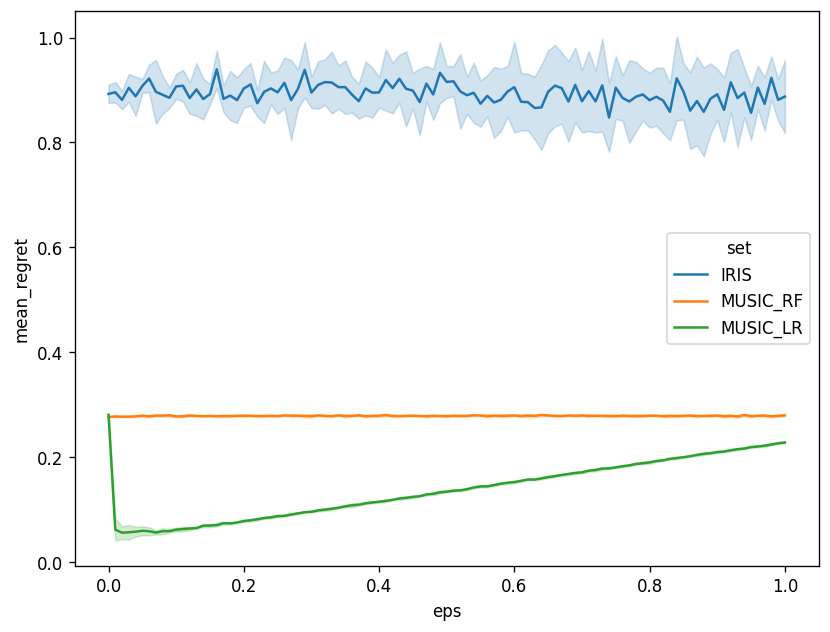

In [18]:
set1_eps1['set'] = 'IRIS'
set2_eps1['set'] = 'MUSIC_RF'
set3_eps1['set'] = 'MUSIC_LR'

eps1_concat = pd.concat([set1_eps1,set2_eps1,set3_eps1]).reset_index(drop=True)

plt.figure(figsize=(8, 6), dpi=120)
sns.lineplot(x = 'eps',y = 'mean_regret', hue='set', ci='sd', data= eps1_concat)

#### Annealing-EpsilonGreedy - temperature grid search

<AxesSubplot: xlabel='i', ylabel='mean_regret'>

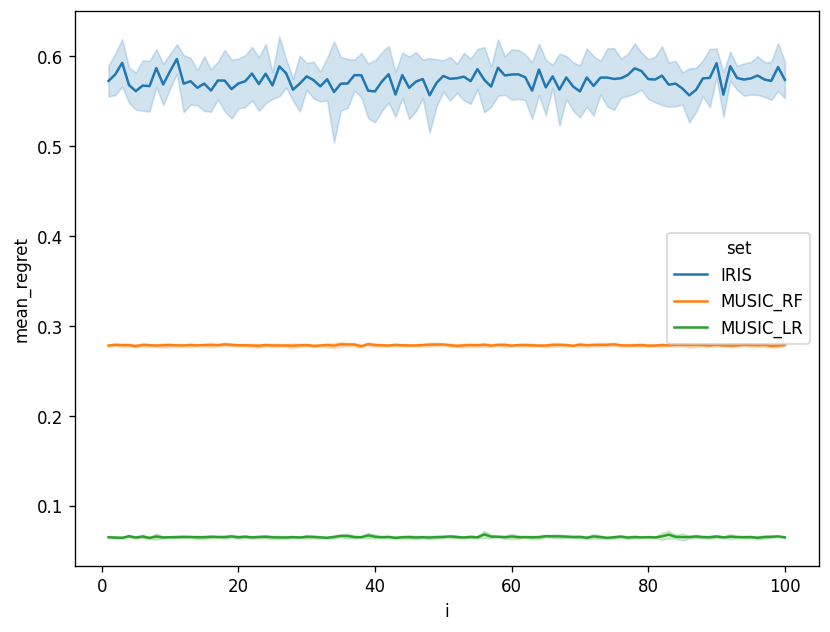

In [19]:
set1_eps2['set'] = 'IRIS'
set2_eps2['set'] = 'MUSIC_RF'
set3_eps2['set'] = 'MUSIC_LR'

eps2_concat = pd.concat([set1_eps2,set2_eps2,set3_eps2]).reset_index(drop=True)

plt.figure(figsize=(8, 6), dpi=120)
sns.lineplot(x = 'i',y = 'mean_regret', hue='set', ci='sd',data= eps2_concat)

#### Soft-max - grid search temperature grid search

<AxesSubplot: xlabel='log_temperature', ylabel='mean_regret'>

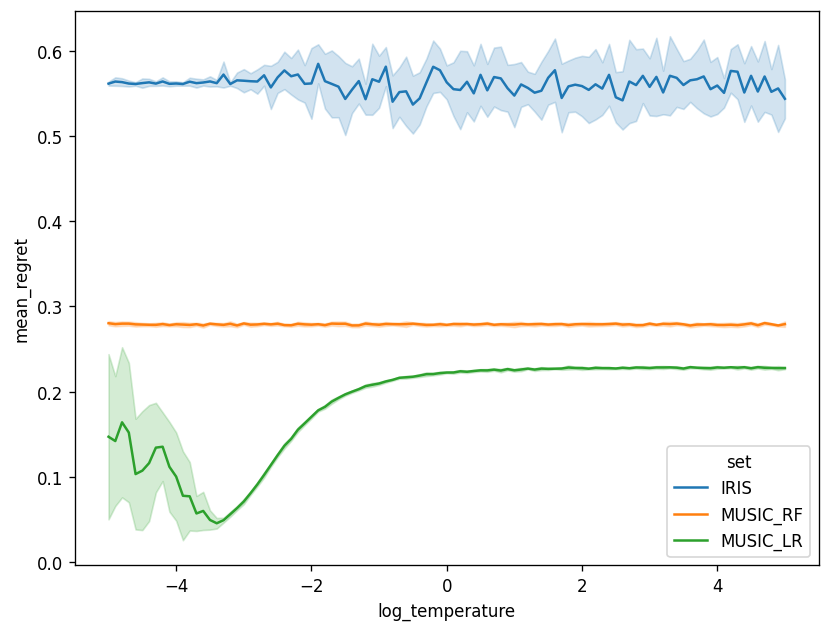

In [20]:
set1_softmax['log_temperature'] = np.log(set1_softmax['temp'])
set2_softmax['log_temperature'] = np.log(set2_softmax['temp'])
set3_softmax['log_temperature'] = np.log(set3_softmax['temp'])

set1_softmax['set'] = 'IRIS'
set2_softmax['set'] = 'MUSIC_RF'
set3_softmax['set'] = 'MUSIC_LR'

softmax_concat = pd.concat([set1_softmax,set2_softmax,set3_softmax]).reset_index(drop=True)

plt.figure(figsize=(8, 6), dpi=120)
sns.lineplot(x = 'log_temperature',y = 'mean_regret', hue='set', ci='sd', data= softmax_concat)

#### UCB - alpha grid search

<AxesSubplot: xlabel='alpha', ylabel='mean_regret'>

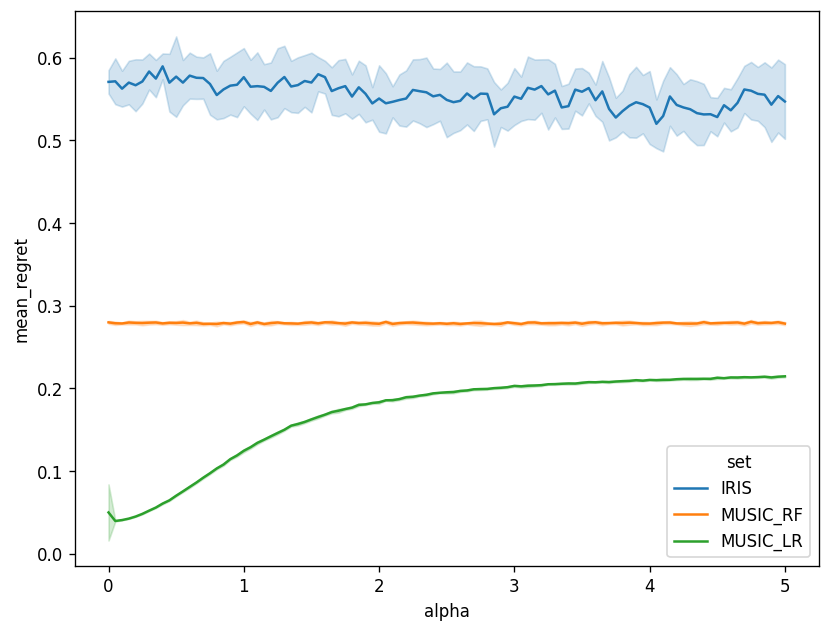

In [21]:
set1_ucb1['set'] = 'IRIS'
set2_ucb1['set'] = 'MUSIC_RF'
set3_ucb1['set'] = 'MUSIC_LR'

ucb1_concat = pd.concat([set1_ucb1,set2_ucb1,set3_ucb1]).reset_index(drop=True)

plt.figure(figsize=(8, 6), dpi=120)
sns.lineplot(x = 'alpha',y = 'mean_regret', hue='set',  ci='sd',data= ucb1_concat)

#### LinUCB - delta grid search

<AxesSubplot: xlabel='delta', ylabel='mean_regret'>

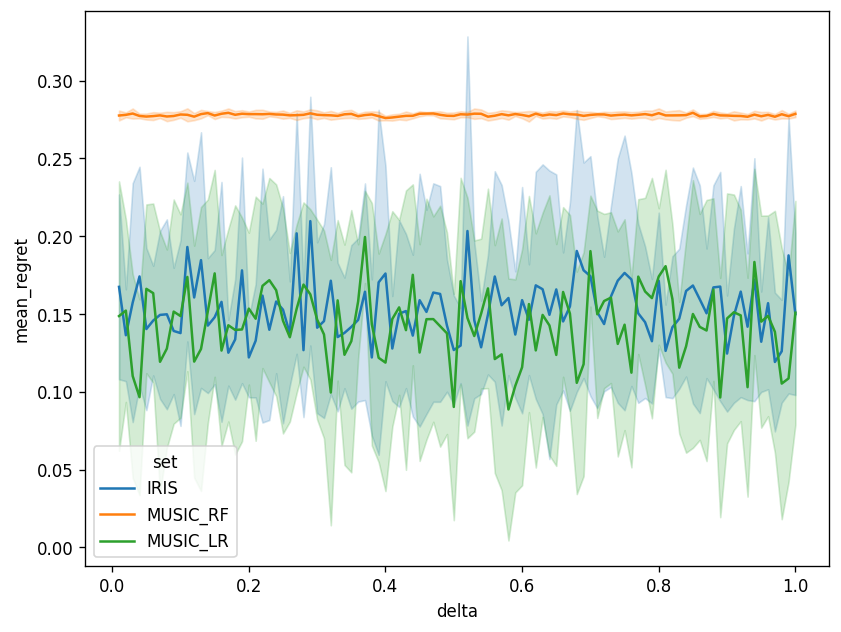

In [22]:
set1_linUCB['set'] = 'IRIS'
set2_linUCB['set'] = 'MUSIC_RF'
set3_linUCB['set'] = 'MUSIC_LR'

linUCB_concat = pd.concat([set1_linUCB,set2_linUCB,set3_linUCB]).reset_index(drop=True)

plt.figure(figsize=(8, 6), dpi=120)
sns.lineplot(x = 'delta',y = 'mean_regret', hue='set',  ci='sd',data= linUCB_concat)

# Experiment & Result 2 : 최적 hyper-parameter에서 각 알고리즘 performance 변화 

현실에서는 불가능하지만 모든 데이터셋에서 각 알고리즘의 최적의 hyper-parameter를 알고 있다고 가정하고, 해당 값으로 고정하고 알고리즘을 비교해 보았습니다. 

In [23]:
set_1_experiment = pd.DataFrame()
for i in range(10) : 
    print(i)
    idx_shfl = np.random.permutation(np.arange(Reward_1.shape[0]))
    Temp_Reward = Reward_1[idx_shfl,:]
    Temp_X = X_1[idx_shfl,:]

    set1_t_eps1 = EpsilonGreedy(epsilon=0.05, counts = None, values = None)
    set1_t_eps1.initialize(n_arms = Temp_Reward.shape[1])
    set1_t_eps1_simul = set1_t_eps1.run_simul(Temp_Reward)


    set1_t_eps2 = AnnealingEpsilonGreedy(counts = None, values = None)
    set1_t_eps2.initialize(n_arms = Temp_Reward.shape[1])
    set1_t_eps2_simul = set1_t_eps2.run_simul(Temp_Reward)

    set1_t_softmax = Softmax(temperature = 0.05, counts = None, values = None)
    set1_t_softmax.initialize(n_arms = Temp_Reward.shape[1])
    set1_t_softmax_simul = set1_t_softmax.run_simul(Temp_Reward)

    set1_t_ucb1 = UCB1(counts = None, values = None, alpha = 1)
    set1_t_ucb1.initialize(n_arms = Temp_Reward.shape[1])
    set1_t_ucb1_simul = set1_t_ucb1.run_simul(Temp_Reward)


    set1_t_linucb = LinUCB(alpha = (1+np.sqrt(np.log(2/0.1)/2)), n_features = Temp_X.shape[1])
    set1_t_linucb.initialize(n_arms =Temp_Reward.shape[1])
    set1_t_linucb_simul = set1_t_linucb.run_simul(Temp_X, Temp_Reward)

    set1_t_opt_return = np.cumsum(set1_t_eps1_simul['max']) / (np.array(set1_t_eps1_simul.index)+1)
    set1_t_eps1_return = np.cumsum(set1_t_eps1_simul['reward']) / (np.array(set1_t_eps1_simul.index)+1)
    set1_t_eps2_return = np.cumsum(set1_t_eps2_simul['reward']) / (np.array(set1_t_eps1_simul.index)+1)
    set1_t_softmax_return = np.cumsum(set1_t_softmax_simul['reward']) / (np.array(set1_t_eps1_simul.index)+1)
    set1_t_ucb1_return = np.cumsum(set1_t_ucb1_simul['reward']) / (np.array(set1_t_eps1_simul.index)+1)
    set1_t_linucb_return = np.cumsum(set1_t_linucb_simul['reward']) / (np.array(set1_t_eps1_simul.index)+1)

    set1_t_concat = pd.concat([pd.DataFrame({'Model':'OPT','step':np.arange(1,151),'mean return':set1_t_opt_return}),
                               pd.DataFrame({'Model':'EPS1','step':np.arange(1,151),'mean return':set1_t_eps1_return}),
                               pd.DataFrame({'Model':'EPS2','step':np.arange(1,151),'mean return':set1_t_eps2_return}),
                               pd.DataFrame({'Model':'SOFTMAX','step':np.arange(1,151),'mean return':set1_t_softmax_return}),
                               pd.DataFrame({'Model':'UCB1','step':np.arange(1,151),'mean return':set1_t_ucb1_return}),
                               pd.DataFrame({'Model':'LINUCB','step':np.arange(1,151),'mean return':set1_t_linucb_return})],axis=0).reset_index(drop=True)

    set_1_experiment = set_1_experiment.append(set1_t_concat)





0
1
2
3
4
5
6
7
8
9


## Data set 1

<AxesSubplot: xlabel='step', ylabel='mean return'>

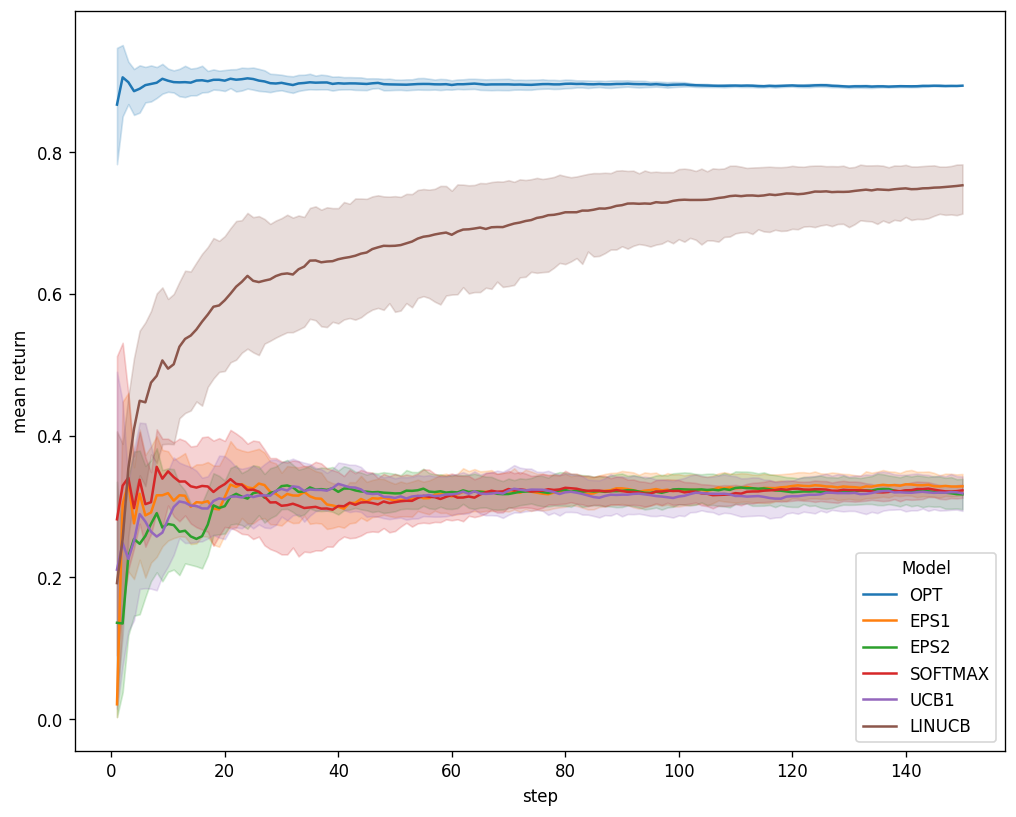

In [24]:
set_1_experiment = set_1_experiment.reset_index()
plt.figure(figsize=(10, 8), dpi=120)
sns.lineplot(x = 'step',y = 'mean return', hue='Model', data= set_1_experiment, legend='brief')



## Data set 2

In [25]:
set_2_experiment = pd.DataFrame()
for i in range(10) : 
    print(i)
    idx_shfl = np.random.permutation(np.arange(Reward_2.shape[0]))
    Temp_Reward = Reward_2[idx_shfl,:]
    Temp_X = X_2[idx_shfl,:]

    set2_t_eps1 = EpsilonGreedy(epsilon=0.05, counts = None, values = None)
    set2_t_eps1.initialize(n_arms = Temp_Reward.shape[1])
    set2_t_eps1_simul = set2_t_eps1.run_simul(Temp_Reward)


    set2_t_eps2 = AnnealingEpsilonGreedy(counts = None, values = None)
    set2_t_eps2.initialize(n_arms = Temp_Reward.shape[1])
    set2_t_eps2_simul = set2_t_eps2.run_simul(Temp_Reward)

    set2_t_softmax = Softmax(temperature = 0.05, counts = None, values = None)
    set2_t_softmax.initialize(n_arms = Temp_Reward.shape[1])
    set2_t_softmax_simul = set2_t_softmax.run_simul(Temp_Reward)

    set2_t_ucb1 = UCB1(counts = None, values = None, alpha = 1)
    set2_t_ucb1.initialize(n_arms = Temp_Reward.shape[1])
    set2_t_ucb1_simul = set2_t_ucb1.run_simul(Temp_Reward)


    set2_t_linucb = LinUCB(alpha = (1+np.sqrt(np.log(2/0.1)/2)), n_features = Temp_X.shape[1])
    set2_t_linucb.initialize(n_arms =Temp_Reward.shape[1])
    set2_t_linucb_simul = set2_t_linucb.run_simul(Temp_X, Temp_Reward)

    set2_t_opt_return = np.cumsum(set2_t_eps1_simul['max']) / (np.array(set2_t_eps1_simul.index)+1)
    set2_t_eps1_return = np.cumsum(set2_t_eps1_simul['reward']) / (np.array(set2_t_eps1_simul.index)+1)
    set2_t_eps2_return = np.cumsum(set2_t_eps2_simul['reward']) / (np.array(set2_t_eps1_simul.index)+1)
    set2_t_softmax_return = np.cumsum(set2_t_softmax_simul['reward']) / (np.array(set2_t_eps1_simul.index)+1)
    set2_t_ucb1_return = np.cumsum(set2_t_ucb1_simul['reward']) / (np.array(set2_t_eps1_simul.index)+1)
    set2_t_linucb_return = np.cumsum(set2_t_linucb_simul['reward']) / (np.array(set2_t_eps1_simul.index)+1)

    set2_t_concat = pd.concat([pd.DataFrame({'Model':'OPT','step':np.arange(1,5064),'mean return':set2_t_opt_return}),
                               pd.DataFrame({'Model':'EPS1','step':np.arange(1,5064),'mean return':set2_t_eps1_return}),
                               pd.DataFrame({'Model':'EPS2','step':np.arange(1,5064),'mean return':set2_t_eps2_return}),
                               pd.DataFrame({'Model':'SOFTMAX','step':np.arange(1,5064),'mean return':set2_t_softmax_return}),
                               pd.DataFrame({'Model':'UCB1','step':np.arange(1,5064),'mean return':set2_t_ucb1_return}),
                               pd.DataFrame({'Model':'LINUCB','step':np.arange(1,5064),'mean return':set2_t_linucb_return})],axis=0).reset_index(drop=True)

    set_2_experiment = set_2_experiment.append(set2_t_concat)



0
1
2
3
4
5
6
7
8
9


<AxesSubplot: xlabel='step', ylabel='mean return'>

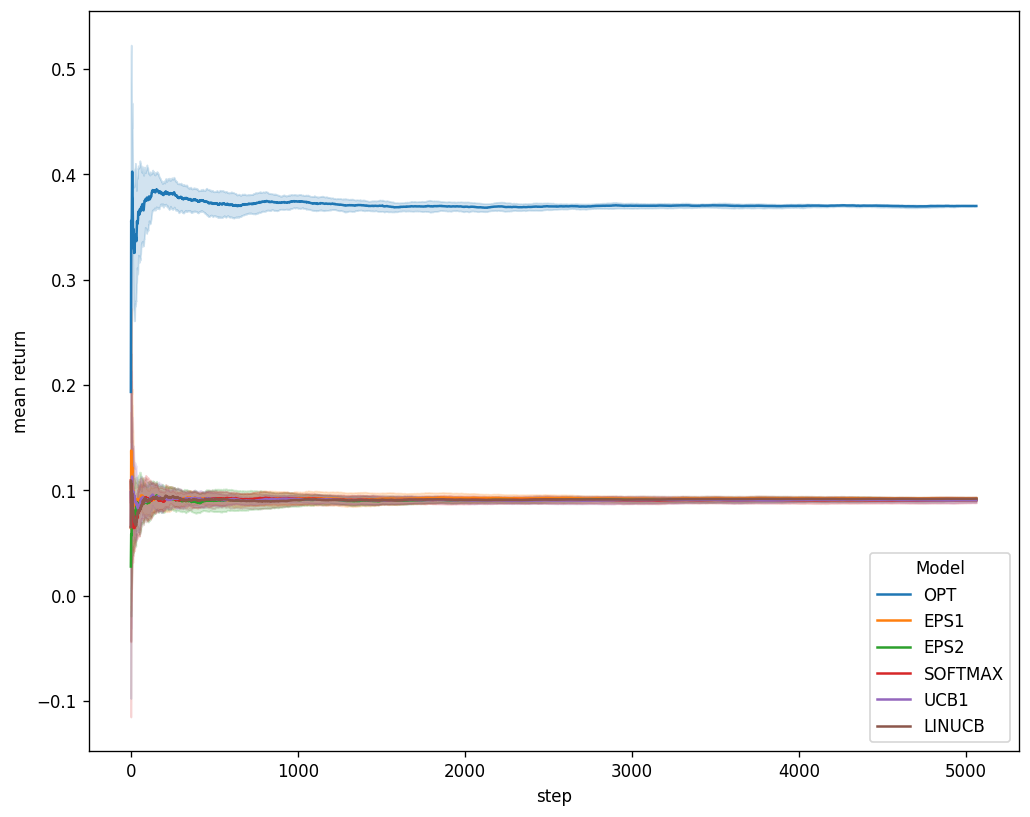

In [26]:
set_2_experiment = set_2_experiment.reset_index()
plt.figure(figsize=(10, 8), dpi=120)
sns.lineplot(x = 'step',y = 'mean return', hue='Model', data= set_2_experiment, ci='sd', legend='brief')

## Data set 3

In [27]:
set_3_experiment = pd.DataFrame()
for i in range(10) : 
    idx_shfl = np.random.permutation(np.arange(Reward_3.shape[0]))
    Temp_Reward = Reward_3[idx_shfl,:]
    Temp_X = X_3[idx_shfl,:]

    set3_t_eps1 = EpsilonGreedy(epsilon=0.05, counts = None, values = None)
    set3_t_eps1.initialize(n_arms = Temp_Reward.shape[1])
    set3_t_eps1_simul = set3_t_eps1.run_simul(Temp_Reward)


    set3_t_eps2 = AnnealingEpsilonGreedy(counts = None, values = None)
    set3_t_eps2.initialize(n_arms = Temp_Reward.shape[1])
    set3_t_eps2_simul = set3_t_eps2.run_simul(Temp_Reward)

    set3_t_softmax = Softmax(temperature = 0.05, counts = None, values = None)
    set3_t_softmax.initialize(n_arms = Temp_Reward.shape[1])
    set3_t_softmax_simul = set3_t_softmax.run_simul(Temp_Reward)

    set3_t_ucb1 = UCB1(counts = None, values = None, alpha = 1)
    set3_t_ucb1.initialize(n_arms = Temp_Reward.shape[1])
    set3_t_ucb1_simul = set3_t_ucb1.run_simul(Temp_Reward)


    set3_t_linucb = LinUCB(alpha = (1+np.sqrt(np.log(2/0.5)/2)), n_features = Temp_X.shape[1])
    set3_t_linucb.initialize(n_arms =Temp_Reward.shape[1])
    set3_t_linucb_simul = set3_t_linucb.run_simul(Temp_X, Temp_Reward)

    set3_t_opt_return = np.cumsum(set3_t_eps1_simul['max']) / (np.array(set3_t_eps1_simul.index)+1)
    set3_t_eps1_return = np.cumsum(set3_t_eps1_simul['reward']) / (np.array(set3_t_eps1_simul.index)+1)
    set3_t_eps2_return = np.cumsum(set3_t_eps2_simul['reward']) / (np.array(set3_t_eps1_simul.index)+1)
    set3_t_softmax_return = np.cumsum(set3_t_softmax_simul['reward']) / (np.array(set3_t_eps1_simul.index)+1)
    set3_t_ucb1_return = np.cumsum(set3_t_ucb1_simul['reward']) / (np.array(set3_t_eps1_simul.index)+1)
    set3_t_linucb_return = np.cumsum(set3_t_linucb_simul['reward']) / (np.array(set3_t_eps1_simul.index)+1)

    set3_t_concat = pd.concat([pd.DataFrame({'Model':'OPT','step':np.arange(1,5064),'mean return':set3_t_opt_return}),
                               pd.DataFrame({'Model':'EPS1','step':np.arange(1,5064),'mean return':set3_t_eps1_return}),
                               pd.DataFrame({'Model':'EPS2','step':np.arange(1,5064),'mean return':set3_t_eps2_return}),
                               pd.DataFrame({'Model':'SOFTMAX','step':np.arange(1,5064),'mean return':set3_t_softmax_return}),
                               pd.DataFrame({'Model':'UCB1','step':np.arange(1,5064),'mean return':set3_t_ucb1_return}),
                               pd.DataFrame({'Model':'LINUCB','step':np.arange(1,5064),'mean return':set3_t_linucb_return})],axis=0).reset_index(drop=True)

    set_3_experiment = set_3_experiment.append(set3_t_concat)





<AxesSubplot: xlabel='step', ylabel='mean return'>

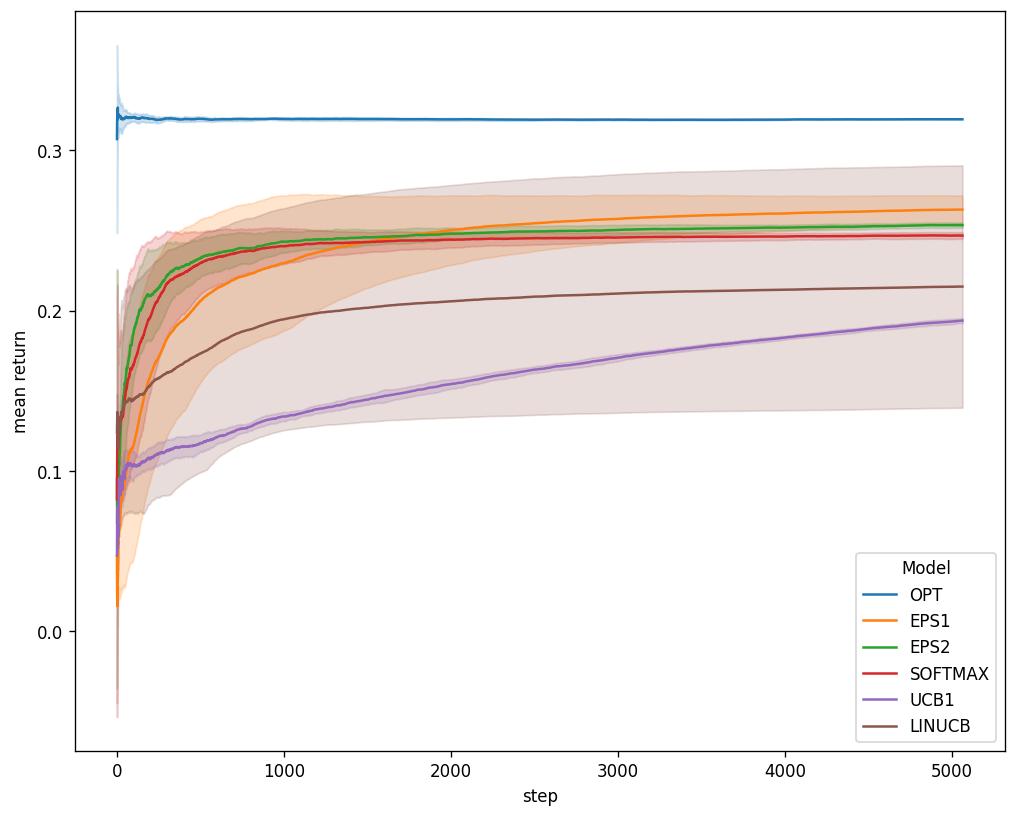

In [28]:
set_3_experiment =set_3_experiment.reset_index()
plt.figure(figsize=(10, 8), dpi=120)
sns.lineplot(x = 'step',y = 'mean return', hue='Model', data= set_3_experiment, ci='sd', legend='brief')

# Discussion -